# An analysis of the State of the Union speeches - Part 2

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Let's start by loading some of the data created in the previous part, so we can continue where we left off:

In [5]:
addresses = pd.read_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    speeches = db['speeches']

Let's double-check that we're getting the full set of speeches:

In [6]:
print(addresses.shape)
print(len(speeches))

(227, 3)
227


## Basic text analysis

Let's ask a few basic questions about this text, by populating our `addresses` dataframe with some extra information. As a reminder, so far we have:

In [7]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Now, let's add the following information to this DF:

* `n_words`: number of words in the speech
* `n_uwords`: number of *unique* words in the speech
* `n_swords`: number of *unique, stemmed* words in the speech
* `n_chars`: number of letters in the speech
* `n_sent`: number of sentences in the speech

For this level of complexity, it's probably best if we go with NLTK. Remember, that `speeches` is our list with all the speeches, indexed in the same way as the `addresses` dataframe:

In [8]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer

def clean_word_tokenize(doc):
    """custom word toenizer which removes stop words and punctuation
    
    Parameters
    ----------
    doc : string
        A document to be tokenized
        
    Returns
    -------
    tokens
    """
    n_sent=[]
    n_words_all=[]
    n_words=[]
    n_uwords=[]
    n_swords=[]
    n_chars=[]
    stop=stopwords.words("english") + list(string.punctuation)
    stemmer=PorterStemmer()
    #countLetters= charCounter(string.letters)
    for i in doc:
        n_chars=np.append(n_chars,len(i))
        n_sent=np.append(n_sent,len(nltk.sent_tokenize(i)))
        n_words_all=np.append(n_words_all,len(nltk.word_tokenize(i)))
        n_words=np.append(n_words,len([word for word in nltk.word_tokenize(i) if word not in stop]))
        i=i.lower()
        n_uwords=np.append(n_uwords,len(list(set([word for word in nltk.word_tokenize(i) if word not in stop]))))
        n_swords=np.append(n_swords,len([stemmer.stem(word) for word in list(set([word for word in nltk.word_tokenize(i)]))]))      
    columns=['n_sent','n_words_all','n_words','n_uwords','n_swords','n_chars']
    df=pd.DataFrame({'n_sent':n_sent,'n_words_all':n_words_all,'n_words':n_words,'n_uwords':n_uwords,'n_swords':n_swords,'n_chars':n_chars},columns=columns)          
    return df

Now we compute these quantities for each speech, as well as saving the set of unique, stemmed words for each speech, which we'll need later to construct the complete term-document matrix across all speeches.

In [9]:
results=clean_word_tokenize(speeches)
addresses=addresses.join(results)
addresses.head()

,president,title,date,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
0,George Washington,State of the Union Address,1790-01-08,24.0,1178.0,538.0,387.0,458.0,6753.0
1,George Washington,State of the Union Address,1790-12-08,40.0,1515.0,683.0,498.0,583.0,8455.0
2,George Washington,State of the Union Address,1791-10-25,60.0,2487.0,1136.0,715.0,799.0,14203.0
3,George Washington,State of the Union Address,1792-11-06,61.0,2298.0,1042.0,666.0,753.0,12764.0
4,George Washington,State of the Union Address,1793-12-03,56.0,2132.0,972.0,688.0,783.0,11696.0


*** difference in n_unwords, and n_swords. 

In [35]:
speech_words=[]
speeches_cleaned=[]
stop=stopwords.words("english") + list(string.punctuation)
stemmer=PorterStemmer()
for i in np.arange(len(speeches)):
    speeches[i]=speeches[i].lower()
    speeches_cleaned.append([stemmer.stem(word) for word in nltk.word_tokenize(speeches[i]) if word not in stop])
    speech_words.append([word for word in nltk.word_tokenize(speeches[i])])

Let's look at a summary of these 

In [11]:
pd.options.display.precision = 2
addresses.describe()

,n_sent,n_words_all,n_words,n_uwords,n_swords,n_chars
count,227.00,227.00,227.00,227.00,227.00,227.00
mean,266.15,8304.19,4047.24,1604.49,1715.57,45473.15
std,178.80,5871.69,2900.51,740.81,748.86,33020.36
min,24.00,1059.00,538.00,387.00,453.00,5649.00
25%,165.00,4396.00,2190.50,1055.50,1168.00,23394.50
50%,240.00,6655.00,3388.00,1494.00,1606.00,36677.00
75%,347.50,10055.00,4801.50,1958.00,2073.50,55211.00
max,1343.00,36974.00,21041.00,4241.00,4361.00,218009.00


## Visualizing characteristics of the speeches

Now we explore some of the relationships between the speeches, their authors, and time.

How properties of the speeches change over time.

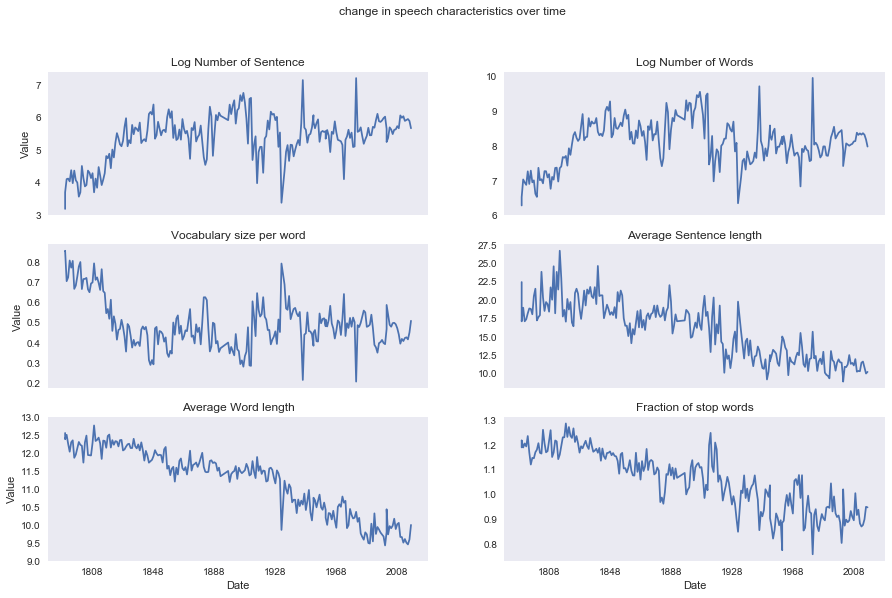

In [12]:
# Use Seaborn to provide a plot such as this, and discuss:
import math 
log_n_sent=[]
for i in addresses['n_sent']:
    log_n_sent=np.append(log_n_sent,math.log(i,math.e))    
log_n_words=[]
for i in addresses['n_words']:
    log_n_words=np.append(log_n_words,math.log(i,math.e))

vocab_per_word=(addresses['n_swords'])/addresses['n_words']
mean_word_length=addresses['n_chars']/addresses['n_words']
mean_sent_length=addresses['n_words']/addresses['n_sent']
frac_stop_word=(addresses['n_words_all']-addresses['n_words'])/addresses['n_words']
Date=addresses['date'].dt.year

f1,axarr = plt.subplots(3,2,sharex=True,linewidth=0.001)
f1.set_figwidth(15)
f1.set_figheight(9)
ax=plt.gca()
#set title and range of x axies
plt.suptitle( 'change in speech characteristics over time')
plt.xticks(np.arange(1808,2009,40))
#plot[0][0], Date v.s. Log Number of Sentence
axarr[0,0].set_ylabel("Value")
axarr[0,0].set_title("Log Number of Sentence")
axarr[0,0].plot(Date,log_n_sent)
axarr[0,0].set_yticks(np.arange(3,8,1))

#plot[0][1], Date v.s. Log Number of Words
axarr[0,1].set_title("Log Number of Words")
axarr[0,1].plot(Date,log_n_words)
axarr[0,1].set_yticks(np.arange(6,11,1))

#plot[1][0], Date v.s. Vocabulary size per word
axarr[1][0].set_ylabel("Value")
axarr[1,0].set_title("Vocabulary size per word")
axarr[1,0].plot(Date,vocab_per_word)
axarr[1,0].set_yticks(np.arange(0.2,0.9,0.1)) 

#plot[1][1], Date v.s. Average Sentence length
axarr[1,1].set_title("Average Sentence length")
axarr[1,1].plot(Date,mean_sent_length)
axarr[1,1].set_yticks(np.arange(10.0,27.6,2.5)) 

#plot[2][0], Date v.s. Average Word length
axarr[2,0].plot(Date,mean_word_length)
axarr[2,0].set_title("Average Word length")
axarr[2][0].set_ylabel("Value")
axarr[2][0].set_xlabel("Date")
axarr[2,0].set_yticks(np.arange(9,13.1,0.5)) 
# ax.set_yticks(np.linspace(9,13,8))
# ax.yaxis.set_ticks(np.arange(9, 13, 8))
#plot[2][1], Date v.s. Fraction of stop words
axarr[2,1].plot(Date,frac_stop_word)
axarr[2,1].set_title("Fraction of stop words")
axarr[2][1].set_xlabel("Date")
axarr[2,1].set_yticks(np.arange(0.8,1.4,0.1))  
f1.savefig("fig/speech_changes.png")

*** The graph of number of sentences and number of words seems to have a positive upward trend which means, which means the there are more and more words and sentence in the State of Union address as time approach present. ***

***The graph of vocabulary size per word ,average sentence length, average word length and Fraction of stop words semms to have a negative downward trends. This could suggest that the President were choosing to use less compliate words and sentence, keeping the language plain and simple, as time goes present.***

***The more detailed analysis will be included in the report***


Now for the distributions by president

In [13]:
# add variable to original data frame
president=addresses['president']
values=pd.DataFrame({"president":president,"log_n_sent":log_n_sent,"log_n_words":log_n_words,"vocab_per_word":vocab_per_word,"mean_word_length":mean_word_length,"mean_sent_length":mean_sent_length,"frac_stop_word":frac_stop_word})

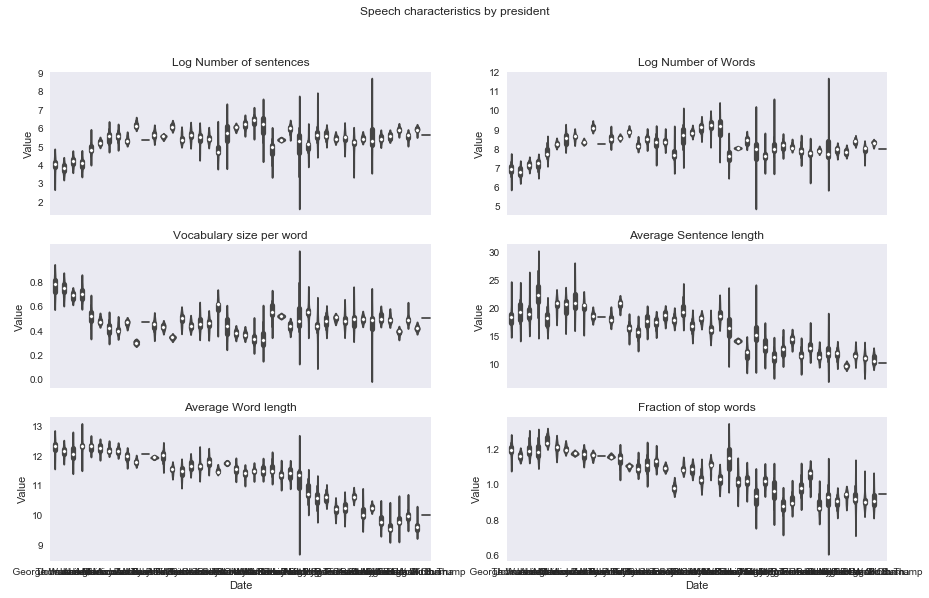

In [23]:
f2,axarr = plt.subplots(3,2,sharex=True)
f2.set_figwidth(15)
f2.set_figheight(9)
ax=plt.gca()
#set title and range of x axies
plt.suptitle( 'Speech characteristics by president')
plt.xticks(np.arange(1808,2009,40))

#plot[0][0],  Log Number of Sentence by president
sns.violinplot(data=values, x="president", y="log_n_sent",ax=axarr[0,0])
axarr[0,0].set_yticks(np.arange(2,10,1))
axarr[0][0].set_ylabel("Value")
axarr[0][0].set_xlabel("")
axarr[0,0].set_title("Log Number of sentences")

#plot[0][1],  Log Number of Words by president
axarr[0,1].set_title("Log Number of Words")
sns.violinplot(data=values, x="president", y="log_n_words",ax=axarr[0,1])
axarr[0,1].set_yticks(np.arange(5,13,1))
axarr[0][1].set_ylabel("Value")
axarr[0][1].set_xlabel("")

#plot[1][0], Vocabulary size per word by president

axarr[1,0].set_title("Vocabulary size per word")
sns.violinplot(data=values, x="president", y="vocab_per_word",ax=axarr[1,0])
axarr[1,0].set_yticks(np.arange(0,1,0.2)) 
axarr[1][0].set_ylabel("Value")
axarr[1][0].set_xlabel("")

#plot[1][1], Average Sentence length by president
axarr[1,1].set_title("Average Sentence length")
sns.violinplot(data=values, x="president", y="mean_sent_length",ax=axarr[1,1])
axarr[1,1].set_yticks(np.arange(10,30.1,5)) 
axarr[1][1].set_ylabel("Value")
axarr[1][1].set_xlabel("")

#plot[2][0], Average Word length by president
sns.violinplot(data=values, x="president", y="mean_word_length",ax=axarr[2,0])
axarr[2,0].set_title("Average Word length")
axarr[2][0].set_ylabel("Value")
axarr[2][0].set_xlabel("Date")
axarr[2,0].set_yticks(np.arange(9,14,1)) 


#plot[2][1], Fraction of stop words by president
sns.violinplot(data=values, x="president", y="frac_stop_word",ax=axarr[2,1])
axarr[2,1].set_title("Fraction of stop words")
axarr[2][1].set_xlabel("Date")
axarr[2][1].set_ylabel("Value")
axarr[2,1].set_yticks(np.arange(0.6,1.3,0.2))  
f2.savefig("fig/speech_characteristics.png")

*** The trend of the distribution by Presidents is somewhat similar to the trend in the one by Year, with the first two graph positive increassing trend and the rest of the graph slightly drcreasing trend. ***

*** more detail analysis will be put in the report*** 

## Intermediate results storage

Since this may have taken a while, we now serialize the results we have for further use. Note that we don't overwrite our original dataframe file, so we can load both (even though in this notebook we reused the name `addresses`):

In [24]:
addresses.to_hdf('results/df2.h5', 'addresses')

with shelve.open('results/vars2') as db:
    db['speech_words'] = speech_words
    db['speeches_cleaned'] = speeches_cleaned

NameError: name 'speech_words' is not defined